In [8]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_train_data, get_test_data, get_X_y
from py_files.helper_funcs import set_np_pd_display_params
from py_files.features import generate_features
from config import data_path
from shapely.wkt import loads
import xgboost as xgb
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation
from IPython.display import HTML
import json
from copy import deepcopy
import pickle

from sklearn.model_selection import train_test_split

set_np_pd_display_params(np, pd)

# load NYC roads as geopandas

In [9]:
X, y = get_X_y(force_clean=True)

In [10]:
nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")
nyc_df = nyc_df.loc[:, ['the_geom']]

# Convert the "the_geom" column to Shapely geometries
nyc_df['the_geom_geopandas'] = nyc_df['the_geom'].apply(loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(nyc_df, geometry='the_geom_geopandas')

min_lon, min_lat, max_lon, max_lat = gdf['the_geom_geopandas'].total_bounds

/tmp/ipykernel_55165/1071620226.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")


In [12]:
code_str = """
nyc_df = pd.read_csv(f"{data_path}/Centerline.csv")
nyc_df = nyc_df.loc[:, ['the_geom']]

# Convert the "the_geom" column to Shapely geometries
nyc_df['the_geom_geopandas'] = nyc_df['the_geom'].apply(loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(nyc_df, geometry='the_geom_geopandas')

min_lon, min_lat, max_lon, max_lat = gdf['the_geom_geopandas'].total_bounds
"""

with open("misc/lat_long_bounds.json", "w+") as file:
    lat_lon_min_max = {
        'lat': {
            'min': min_lat,
            'max': max_lat
        },
        'lon': {
            'min': min_lon,
            'max': max_lon
        },
        'code_str': code_str
    }
    json.dump(lat_lon_min_max, file, indent=2)

In [11]:
X_small = X.loc[(X['pickup_longitude'] >= min_lon) & (X['pickup_longitude'] <= max_lon) &
            (X['pickup_latitude'] >= min_lat) & (X['pickup_latitude'] <= max_lat), :].copy()
X_small = X_small.loc[(X_small['dropoff_longitude'] >= min_lon) & (X_small['dropoff_longitude'] <= max_lon) &
            (X_small['dropoff_latitude'] >= min_lat) & (X_small['dropoff_latitude'] <= max_lat), :].copy()

In [14]:
print(X_small.shape)
print(X.shape)
display(X_small.head())
display(X.head())

(1441715, 23)
(1442663, 23)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm
0,id2875421,1,2016-03-14 17:24:55,1,-73.9821548,40.7679367,-73.9646301,40.7656021,3,True,False,False,False,False,False,17,24,False,True,False,-0.9659258,-0.2588190,0.4050858
1,id2377394,0,2016-06-12 00:43:35,1,-73.9804153,40.7385635,-73.9994812,40.7311516,6,False,False,True,False,False,False,0,43,False,False,False,0.0000000,1.0000000,0.8957718
2,id3858529,1,2016-01-19 11:35:24,1,-73.9790268,40.7639389,-74.0053329,40.7100868,1,False,False,False,False,True,False,11,35,True,False,False,0.2588190,-0.9659258,0.1015537
3,id3504673,1,2016-04-06 19:32:31,1,-74.0100403,40.7199707,-74.0122681,40.7067184,4,False,False,False,False,False,True,19,32,False,False,True,-0.9659258,0.2588190,0.5319466
4,id2181028,1,2016-03-26 13:30:55,1,-73.9730530,40.7932091,-73.9729233,40.7825203,3,False,True,False,False,False,False,13,30,False,True,False,-0.2588190,-0.9659258,0.4701272


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm
0,id2875421,1,2016-03-14 17:24:55,1,-73.9821548,40.7679367,-73.9646301,40.7656021,3,True,False,False,False,False,False,17,24,False,True,False,-0.9659258,-0.2588190,0.4050858
1,id2377394,0,2016-06-12 00:43:35,1,-73.9804153,40.7385635,-73.9994812,40.7311516,6,False,False,True,False,False,False,0,43,False,False,False,0.0000000,1.0000000,0.8957718
2,id3858529,1,2016-01-19 11:35:24,1,-73.9790268,40.7639389,-74.0053329,40.7100868,1,False,False,False,False,True,False,11,35,True,False,False,0.2588190,-0.9659258,0.1015537
3,id3504673,1,2016-04-06 19:32:31,1,-74.0100403,40.7199707,-74.0122681,40.7067184,4,False,False,False,False,False,True,19,32,False,False,True,-0.9659258,0.2588190,0.5319466
4,id2181028,1,2016-03-26 13:30:55,1,-73.9730530,40.7932091,-73.9729233,40.7825203,3,False,True,False,False,False,False,13,30,False,True,False,-0.2588190,-0.9659258,0.4701272


/tmp/ipykernel_55165/2427868507.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


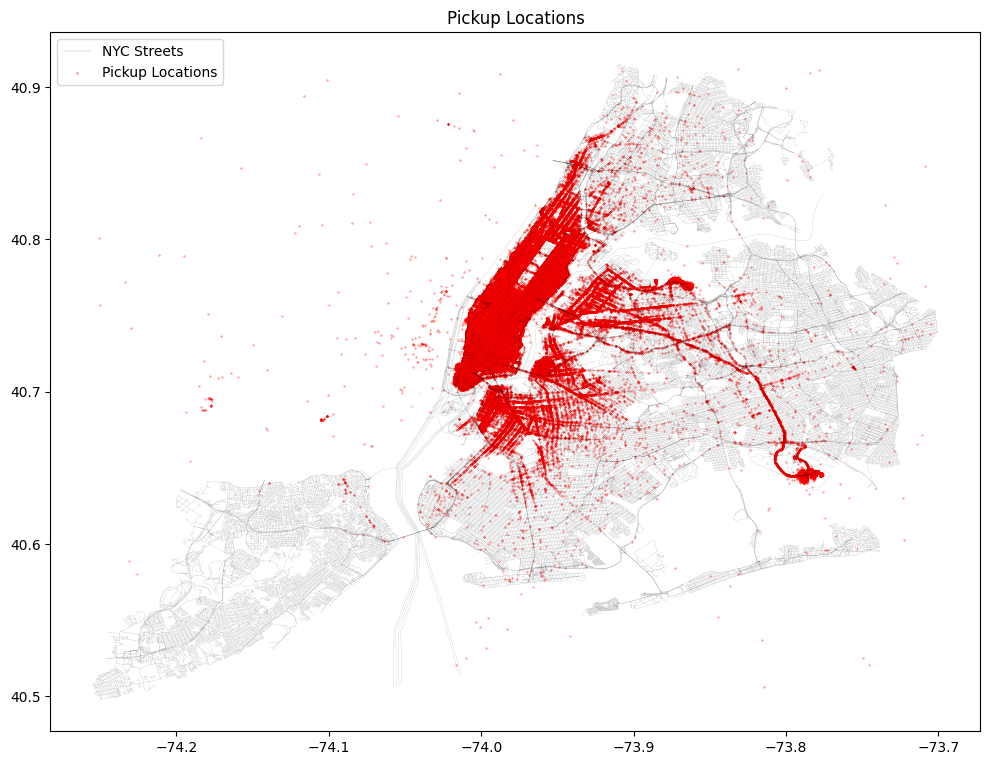

/tmp/ipykernel_55165/2427868507.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


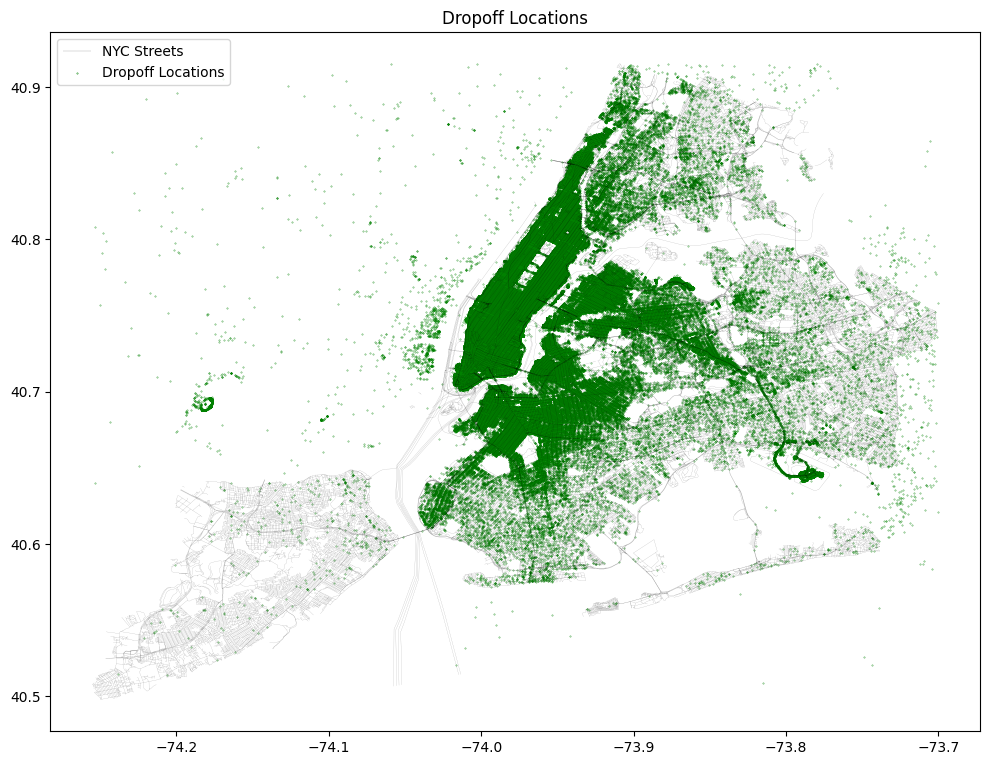

In [12]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

alpha = 0.75

plt.scatter(X_small['pickup_longitude'], X_small['pickup_latitude'], c='red', alpha=alpha, s=0.1, label="Pickup Locations")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Pickup Locations")
plt.show()


# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['dropoff_longitude'], X_small['dropoff_latitude'], c='green', alpha=alpha, s=0.1, label="Dropoff Locations")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Dropoff Locations")
plt.show()

In [24]:
# use sklearn kmeans to cluster the pickup and dropoff locations into 100 clusters
from sklearn.cluster import KMeans

n_clusters = 200

kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42).fit(X_small.loc[:, ['pickup_longitude', 'pickup_latitude']].values)
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42).fit(X_small.loc[:, ['dropoff_longitude', 'dropoff_latitude']].values)

pickup_centers = kmeans_pickup.cluster_centers_
dropoff_centers = kmeans_dropoff.cluster_centers_

X_small['pickup_cluster'] = kmeans_pickup.predict(X_small[['pickup_longitude', 'pickup_latitude']].values)
X_small['dropoff_cluster'] = kmeans_dropoff.predict(X_small[['dropoff_longitude', 'dropoff_latitude']].values)

/home/jeffx/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jeffx/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# save the kmeans_pickup and kmeans_dropoff in the models folder using pickle
import pickle

with open("models/kmeans_200_pickup.pkl", "wb+") as file:
    pickle.dump(kmeans_pickup, file)
    
with open("models/kmeans_200_dropoff.pkl", "wb+") as file:
    pickle.dump(kmeans_dropoff, file)

/tmp/ipykernel_46084/165268429.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


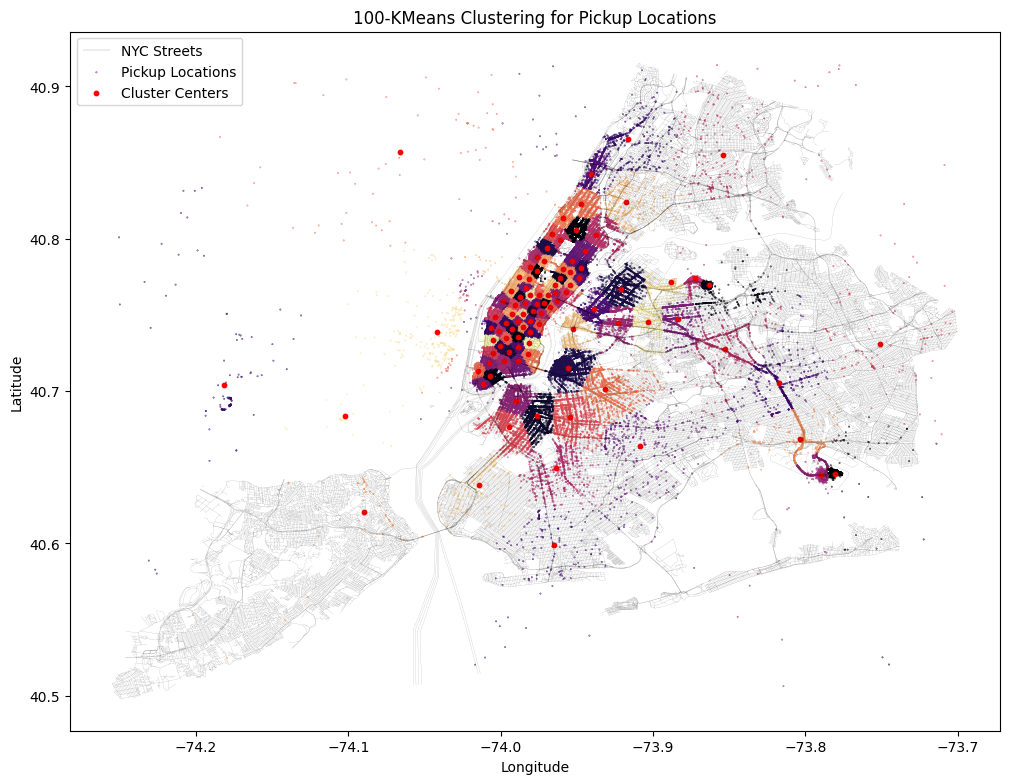

In [32]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['pickup_longitude'], X_small['pickup_latitude'], c=X_small['pickup_cluster'], cmap='magma', alpha=1.0, s=0.1, label="Pickup Locations")
plt.scatter(pickup_centers[:, 0], pickup_centers[:, 1], c='red', alpha=1, s=10, label="Cluster Centers")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("100-KMeans Clustering for Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/tmp/ipykernel_46084/3724819683.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


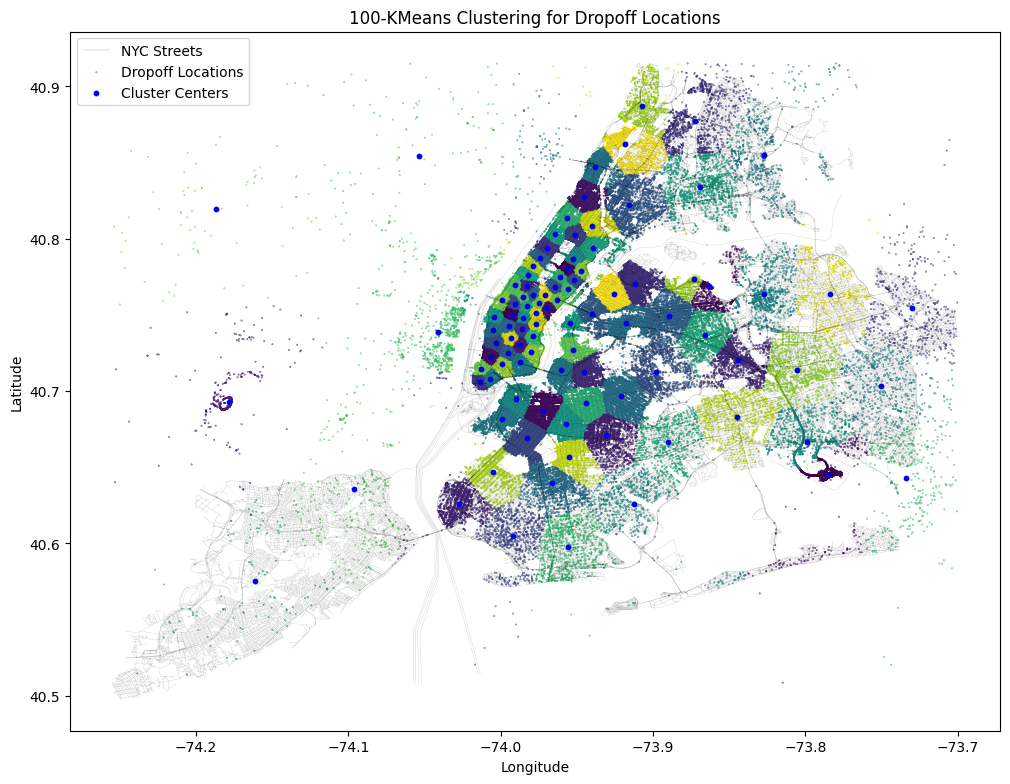

In [31]:
# plot the GeoDataFrame
gdf.plot(linewidth=0.1, edgecolor='black', figsize=(12, 12), alpha=0.5, label="NYC Streets")

plt.scatter(X_small['dropoff_longitude'], X_small['dropoff_latitude'], c=X_small['dropoff_cluster'], cmap='viridis', alpha=1.0, s=0.1, label="Dropoff Locations")
plt.scatter(dropoff_centers[:, 0], dropoff_centers[:, 1], c='blue', alpha=1, s=10, label="Cluster Centers")
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("100-KMeans Clustering for Dropoff Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# creating the cluster distance feature

In [14]:
X, y = get_X_y()
full_df = pd.concat([X, y], axis=1)
display(full_df.head())

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period_morning,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm,trip_duration
0,id2875421,1,2016-03-14 17:24:55,1,-73.9821548,40.7679367,-73.9646301,40.7656021,3,True,False,False,False,False,False,17,24,False,True,False,-0.9659258,-0.2588190,0.4050858,455
1,id2377394,0,2016-06-12 00:43:35,1,-73.9804153,40.7385635,-73.9994812,40.7311516,6,False,False,True,False,False,False,0,43,False,False,False,0.0000000,1.0000000,0.8957718,663
2,id3858529,1,2016-01-19 11:35:24,1,-73.9790268,40.7639389,-74.0053329,40.7100868,1,False,False,False,False,True,False,11,35,True,False,False,0.2588190,-0.9659258,0.1015537,2124
3,id3504673,1,2016-04-06 19:32:31,1,-74.0100403,40.7199707,-74.0122681,40.7067184,4,False,False,False,False,False,True,19,32,False,False,True,-0.9659258,0.2588190,0.5319466,429
4,id2181028,1,2016-03-26 13:30:55,1,-73.9730530,40.7932091,-73.9729233,40.7825203,3,False,True,False,False,False,False,13,30,False,True,False,-0.2588190,-0.9659258,0.4701272,435


In [15]:
df = deepcopy(full_df)

In [16]:
# load kmeans_pickup and kmeans_dropoff from the models folder using pickle
with open("models/kmeans_100_pickup.pkl", "rb") as file:
    kmeans_100_pickup = pickle.load(file)
with open("models/kmeans_100_dropoff.pkl", "rb") as file:
    kmeans_100_dropoff = pickle.load(file)
with open("models/kmeans_200_pickup.pkl", "rb") as file:
    kmeans_200_pickup = pickle.load(file)
with open("models/kmeans_200_dropoff.pkl", "rb") as file:
    kmeans_200_dropoff = pickle.load(file)
    
# predict the clusters for the pickup and dropoff locations using the kmeans_pickup and kmeans_dropoff
df['pickup_100_cluster'] = kmeans_100_pickup.predict(df[['pickup_longitude', 'pickup_latitude']].values)
df['dropoff_100_cluster'] = kmeans_100_dropoff.predict(df[['dropoff_longitude', 'dropoff_latitude']].values)
df['pickup_200_cluster'] = kmeans_200_pickup.predict(df[['pickup_longitude', 'pickup_latitude']].values)
df['dropoff_200_cluster'] = kmeans_200_dropoff.predict(df[['dropoff_longitude', 'dropoff_latitude']].values)

# get the centers
pickup_100_centers = kmeans_100_pickup.cluster_centers_
dropoff_100_centers = kmeans_100_dropoff.cluster_centers_
pickup_200_centers = kmeans_200_pickup.cluster_centers_
dropoff_200_centers = kmeans_200_dropoff.cluster_centers_

def plot_clusters_points(df, centers, pick_or_drop='pick', figsize=(12, 12), alpha=0.5, s=0.1, cmap='magma'):
    

### end load NYC roads as geopandas

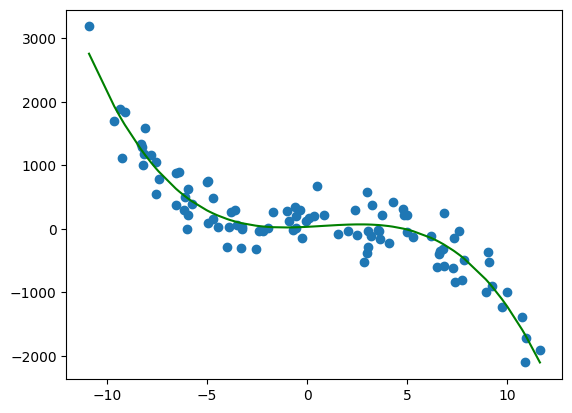

[[1.0000000 -10.8894285 118.5796524 -1291.2646428]
 [1.0000000 -9.6265601 92.6706600 -892.0996808]
 [1.0000000 -8.0826694 65.3295440 -528.0371032]
 [1.0000000 -9.1046091 82.8939074 -754.7166264]
 [1.0000000 -9.3375643 87.1901072 -814.1432330]
 [1.0000000 -8.2297128 67.7281730 -557.3834138]
 [1.0000000 -7.5319928 56.7309158 -427.2968505]
 [1.0000000 -5.9899634 35.8796617 -214.9178607]
 [1.0000000 -7.4145378 54.9753709 -407.6169656]
 [1.0000000 -9.2660523 85.8597249 -795.5806997]
 [1.0000000 -8.2990779 68.8746935 -571.5964450]
 [1.0000000 -8.1203466 65.9400291 -535.4558916]
 [1.0000000 -5.9230068 35.0820098 -207.7909831]
 [1.0000000 -7.8003479 60.8454273 -474.6155006]
 [1.0000000 -6.0746943 36.9019111 -224.1678297]
 [1.0000000 -7.5675966 57.2685186 -433.3850478]
 [1.0000000 -8.1940667 67.1427283 -550.1719910]
 [1.0000000 -6.5434940 42.8173138 -280.1748361]
 [1.0000000 -6.1526597 37.8552215 -232.9102957]
 [1.0000000 -3.2609504 10.6337975 -34.6762860]
 [1.0000000 -4.9245690 24.2513803 -119

In [17]:
def f(x): return -1.7*x**3 + 4.2*x**2 + 3.1*x + 2.3

n = 100
xs = np.linspace(-10, 10, n)
xs_noise = np.linspace(-10, 10, n) + np.random.normal(0, 1, n)
ys = f(xs)
ys_noise = f(xs_noise)
ys_noise += np.random.normal(0, 300, n)

plt.scatter(xs_noise, ys_noise)
#plt.plot(xs, ys, color='red')

X = np.hstack([xs_noise.reshape((-1,1))**j for j in range(0, 4)])

b_hat = np.linalg.inv(X.T @ X) @ X.T @ ys_noise
def approx_f(x, b_hat): return b_hat[0] + b_hat[1]*x + b_hat[2]*x**2 + b_hat[3]*x**3

sortation = np.argsort(xs_noise)
xs_noise = xs_noise[sortation]
ys_noise = ys_noise[sortation]
approx_y = approx_f(xs_noise, b_hat)



plt.plot(xs_noise, approx_f(xs_noise, b_hat), color='green')
plt.show()

print(X)

In [18]:
centerline_df = pd.read_csv(f"{data_path}/Centerline.csv")
display(centerline_df)

/tmp/ipykernel_36052/132701926.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  centerline_df = pd.read_csv(f"{data_path}/Centerline.csv")


,the_geom,PHYSICALID,L_LOW_HN,L_HIGH_HN,R_LOW_HN,R_HIGH_HN,L_ZIP,R_ZIP,L_BLKFC_ID,R_BLKFC_ID,ST_LABEL,STATUS,BIKE_LANE,BOROCODE,ST_WIDTH,CREATED,MODIFIED,TRAFDIR,RW_TYPE,FRM_LVL_CO,TO_LVL_CO,SNOW_PRI,PRE_MODIFI,PRE_DIRECT,PRE_TYPE,POST_TYPE,POST_DIREC,POST_MODIF,FULL_STREE,ST_NAME,BIKE_TRAFD,SEGMENT_TY,SHAPE_Leng
0,MULTILINESTRING ((-73.90600778422906 40.807398...,-1,NaN,NaN,NaN,NaN,10454.0000000,10454.0000000,1422600180,1422600156,BRUCKNER BLVD,2,NaN,2,36,11/29/2007 12:00:00 AM,10/16/2023 12:00:00 AM,FT,1,13,13,C,NaN,NaN,NaN,BLVD,NaN,NaN,BRUCKNER BLVD,BRUCKNER,NaN,R,522.1608911
1,MULTILINESTRING ((-74.01793061274537 40.706174...,3,50,64,51,63,10280.0000000,10280.0000000,212262587,1222601917,BATTERY PL,2,NaN,1,42,11/29/2007 12:00:00 AM,03/17/2017 12:00:00 AM,TW,1,13,13,C,NaN,NaN,NaN,PL,NaN,NaN,BATTERY PL,BATTERY,NaN,U,262.7778123
2,MULTILINESTRING ((-74.01757437049282 40.706839...,5,66,82,65,81,10280.0000000,10280.0000000,1222600642,1222604562,BATTERY PL,2,NaN,1,42,11/29/2007 12:00:00 AM,03/17/2017 12:00:00 AM,TW,1,13,13,C,NaN,NaN,NaN,PL,NaN,NaN,BATTERY PL,BATTERY,NaN,U,259.4159885
3,MULTILINESTRING ((-74.01712051881411 40.707462...,6,84,98,83,101,10280.0000000,10280.0000000,1222600640,1222600933,BATTERY PL,2,NaN,1,42,11/29/2007 12:00:00 AM,03/17/2017 12:00:00 AM,TW,1,13,13,C,NaN,NaN,NaN,PL,NaN,NaN,BATTERY PL,BATTERY,NaN,U,280.4447809
4,MULTILINESTRING ((-74.01693786186667 40.704813...,8,NaN,NaN,NaN,NaN,10280.0000000,10280.0000000,212262587,1222600931,BATTERY PL,2,NaN,1,42,11/29/2007 12:00:00 AM,07/18/2017 12:00:00 AM,TW,1,13,13,C,NaN,NaN,NaN,PL,NaN,NaN,BATTERY PL,BATTERY,NaN,U,32.0701392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121469,MULTILINESTRING ((-73.8123928725374 40.7959213...,201394,6-000,6-068,6-001,6-069,11357.0000000,11357.0000000,0,0,GRACE LN,2,NaN,4,0,09/13/2023 12:00:00 AM,10/19/2023 12:00:00 AM,TW,1,13,13,NaN,NaN,NaN,NaN,LN,NaN,NaN,GRACE LN,GRACE,NaN,U,507.9396512
121470,MULTILINESTRING ((-73.8662900301626 40.6831150...,201397,0,0,318,364,NaN,11208.0000000,2022601280,2022610721,ELDERT LN,2,NaN,3,30,11/29/2007 12:00:00 AM,10/19/2023 12:00:00 AM,TW,1,13,13,C,NaN,NaN,NaN,LN,NaN,NaN,ELDERT LN,ELDERT,NaN,U,441.9218735
121471,MULTILINESTRING ((-74.21472268727592 40.526758...,201401,33,37,0,0,10309.0000000,10309.0000000,1722612336,1722606274,MARETZEK CT,2,NaN,5,18,11/29/2007 12:00:00 AM,10/20/2023 12:00:00 AM,TW,1,13,13,V,NaN,NaN,NaN,CT,NaN,NaN,MARETZEK CT,MARETZEK,NaN,U,78.1711453
121472,MULTILINESTRING ((-74.21576474079232 40.526458...,201402,2,24,1,23,10309.0000000,10309.0000000,1722606274,1722612336,MARETZEK CT,2,NaN,5,18,11/29/2007 12:00:00 AM,10/20/2023 12:00:00 AM,TW,1,13,13,H,NaN,NaN,NaN,CT,NaN,NaN,MARETZEK CT,MARETZEK,NaN,U,309.6166323


# testing data loading

In [19]:
train = get_train_data()
test = get_test_data()
X, y = get_X_y()

display(train)
display(test)
display(X)
display(y)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period,pickup_hour_sin,pickup_hour_cos
0,1,0.4050858,1,-73.9821548,40.7679367,-73.9646301,40.7656021,455,3,True,False,False,False,False,False,17,24,afternoon,-0.9659258,-0.2588190
1,0,0.8957718,1,-73.9804153,40.7385635,-73.9994812,40.7311516,663,6,False,False,True,False,False,False,0,43,night,0.0000000,1.0000000
2,1,0.1015537,1,-73.9790268,40.7639389,-74.0053329,40.7100868,2124,1,False,False,False,False,True,False,11,35,morning,0.2588190,-0.9659258
3,1,0.5319466,1,-74.0100403,40.7199707,-74.0122681,40.7067184,429,4,False,False,False,False,False,True,19,32,evening,-0.9659258,0.2588190
4,1,0.4701272,1,-73.9730530,40.7932091,-73.9729233,40.7825203,435,3,False,True,False,False,False,False,13,30,afternoon,-0.2588190,-0.9659258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,0.5415565,4,-73.9822006,40.7455215,-73.9949112,40.7401695,778,4,False,False,False,False,False,False,13,31,afternoon,-0.2588190,-0.9659258
1458640,0,0.0511867,1,-74.0009460,40.7473793,-73.9701843,40.7965469,655,1,False,False,True,False,False,False,7,35,morning,0.9659258,-0.2588190
1458641,1,0.6169787,1,-73.9591293,40.7687988,-74.0044327,40.7073708,764,4,False,False,False,False,False,False,6,57,night,1.0000000,0.0000000
1458642,0,0.0256264,1,-73.9820786,40.7490616,-73.9746323,40.7571068,373,1,False,False,False,False,True,False,15,56,afternoon,-0.7071068,-0.7071068


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,2016-06-30 23:59:58,1,-73.9881287,40.7320290,-73.9901733,40.7566795
1,1,2016-06-30 23:59:53,1,-73.9642029,40.6799927,-73.9598083,40.6554031
2,1,2016-06-30 23:59:47,1,-73.9974365,40.7375832,-73.9861603,40.7295227
3,2,2016-06-30 23:59:41,1,-73.9560699,40.7719002,-73.9864273,40.7304688
4,1,2016-06-30 23:59:33,1,-73.9702148,40.7614746,-73.9615097,40.7558899
...,...,...,...,...,...,...,...
625129,1,2016-01-01 00:02:52,1,-74.0034637,40.7251053,-74.0012512,40.7336426
625130,1,2016-01-01 00:01:52,1,-74.0063629,40.7437820,-73.9534073,40.7824669
625131,1,2016-01-01 00:01:24,2,-73.9722672,40.7598648,-73.8766022,40.7486649
625132,1,2016-01-01 00:00:28,1,-73.9765015,40.7335625,-73.8542633,40.8917885


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,pickup_hour,pickup_minute,pickup_period,pickup_hour_sin,pickup_hour_cos
0,1,0.4050858,1,-73.9821548,40.7679367,-73.9646301,40.7656021,3,True,False,False,False,False,False,17,24,afternoon,-0.9659258,-0.2588190
1,0,0.8957718,1,-73.9804153,40.7385635,-73.9994812,40.7311516,6,False,False,True,False,False,False,0,43,night,0.0000000,1.0000000
2,1,0.1015537,1,-73.9790268,40.7639389,-74.0053329,40.7100868,1,False,False,False,False,True,False,11,35,morning,0.2588190,-0.9659258
3,1,0.5319466,1,-74.0100403,40.7199707,-74.0122681,40.7067184,4,False,False,False,False,False,True,19,32,evening,-0.9659258,0.2588190
4,1,0.4701272,1,-73.9730530,40.7932091,-73.9729233,40.7825203,3,False,True,False,False,False,False,13,30,afternoon,-0.2588190,-0.9659258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,1,0.5415565,4,-73.9822006,40.7455215,-73.9949112,40.7401695,4,False,False,False,False,False,False,13,31,afternoon,-0.2588190,-0.9659258
1458640,0,0.0511867,1,-74.0009460,40.7473793,-73.9701843,40.7965469,1,False,False,True,False,False,False,7,35,morning,0.9659258,-0.2588190
1458641,1,0.6169787,1,-73.9591293,40.7687988,-74.0044327,40.7073708,4,False,False,False,False,False,False,6,57,night,1.0000000,0.0000000
1458642,0,0.0256264,1,-73.9820786,40.7490616,-73.9746323,40.7571068,1,False,False,False,False,True,False,15,56,afternoon,-0.7071068,-0.7071068


0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

In [20]:
print(X['vendor_id'].unique())

[1 0]


# figuring out data cleaning

In [21]:
import pandas as pd
from config import data_path

train = pd.read_csv(f'{data_path}/train.csv')
test = pd.read_csv(f'{data_path}/test.csv')

cols_to_drop = ['id', 'store_and_fwd_flag', 'dropoff_datetime']

train_cols_to_drop = [c for c in train.columns if c in cols_to_drop]
train_cleaned = train.drop(columns=train_cols_to_drop)

test_cols_to_drop = [c for c in test.columns if c in cols_to_drop]
test_cleaned = test.drop(columns=test_cols_to_drop)


display(train_cleaned)
display(test_cleaned)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,1,-73.9821548,40.7679367,-73.9646301,40.7656021,455
1,1,2016-06-12 00:43:35,1,-73.9804153,40.7385635,-73.9994812,40.7311516,663
2,2,2016-01-19 11:35:24,1,-73.9790268,40.7639389,-74.0053329,40.7100868,2124
3,2,2016-04-06 19:32:31,1,-74.0100403,40.7199707,-74.0122681,40.7067184,429
4,2,2016-03-26 13:30:55,1,-73.9730530,40.7932091,-73.9729233,40.7825203,435
...,...,...,...,...,...,...,...,...
1458639,2,2016-04-08 13:31:04,4,-73.9822006,40.7455215,-73.9949112,40.7401695,778
1458640,1,2016-01-10 07:35:15,1,-74.0009460,40.7473793,-73.9701843,40.7965469,655
1458641,2,2016-04-22 06:57:41,1,-73.9591293,40.7687988,-74.0044327,40.7073708,764
1458642,1,2016-01-05 15:56:26,1,-73.9820786,40.7490616,-73.9746323,40.7571068,373


,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,2016-06-30 23:59:58,1,-73.9881287,40.7320290,-73.9901733,40.7566795
1,1,2016-06-30 23:59:53,1,-73.9642029,40.6799927,-73.9598083,40.6554031
2,1,2016-06-30 23:59:47,1,-73.9974365,40.7375832,-73.9861603,40.7295227
3,2,2016-06-30 23:59:41,1,-73.9560699,40.7719002,-73.9864273,40.7304688
4,1,2016-06-30 23:59:33,1,-73.9702148,40.7614746,-73.9615097,40.7558899
...,...,...,...,...,...,...,...
625129,1,2016-01-01 00:02:52,1,-74.0034637,40.7251053,-74.0012512,40.7336426
625130,1,2016-01-01 00:01:52,1,-74.0063629,40.7437820,-73.9534073,40.7824669
625131,1,2016-01-01 00:01:24,2,-73.9722672,40.7598648,-73.8766022,40.7486649
625132,1,2016-01-01 00:00:28,1,-73.9765015,40.7335625,-73.8542633,40.8917885


# trying nyc on XGBoost vanilla

In [22]:
data_path = "/home/jeffx/ACME/senior/vol3/_Homework/data/nyc-taxi-trip-duration/train.csv"
nyc_data = pd.read_csv(data_path)
rel_cols = [
    'pickup_datetime', 'dropoff_datetime', 'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
    'dropoff_latitude', 'trip_duration']
data = nyc_data[rel_cols].copy()
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime']).astype('int64') // 10**9
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime']).astype('int64') // 10**9
# scale the pickup and dropoff datetimes with min-max scaling
data['pickup_datetime'] = (data['pickup_datetime'] - data['pickup_datetime'].min()) / (data['pickup_datetime'].max() - data['pickup_datetime'].min())
data['dropoff_datetime'] = (data['dropoff_datetime'] - data['dropoff_datetime'].min()) / (data['dropoff_datetime'].max() - data['dropoff_datetime'].min())

X = data.drop('trip_duration', axis=1).copy().values
y = data['trip_duration'].copy().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regres = xgb.XGBRegressor()
xgb_regres.fit(X_train, y_train)
y_pred = xgb_regres.predict(X_test)
y_pred = y_pred.astype(int)
y_pred[y_pred < 0] = 0

print(y_pred[y_pred < 0])

print(np.sum(y_pred >= 0), len(y_pred))

from sklearn.metrics import mean_squared_error
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

# compute the Root Mean Squared Logarithmic Error
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y_pred))))
print("RMSLE: ", rmsle(y_test, y_pred))

[]
291729 291729
RMSE:  2924.022960643033
RMSLE:  0.5802788877334573


# predict type of exercise

<h1>Question 5.18</h1>

Apply a random forest regressor or classifier to your final project dataset.

(i) Optimize the choice of hyperparameters, including <code>n_estimators</code>, <code>max_depth</code> and <code>max_features</code>.

(ii) Compare the performance of the random forest to the performance of other types of models on this dataset.

(iii) If appropriate for this dataset, identify the three most and least important features. If this is not appropriate to do for this dataset, explain why it is not.



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_california_housing, load_digits
from sklearn.model_selection import train_test_split
from seaborn import load_dataset as sns_load_dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
import json
import xgboost as xgb

data_path = "/home/jeffx/ACME/WearableHealthPredictor/data"

np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 15)
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
pd.set_option('display.float_format', lambda x: "{0:0.7f}".format(x))
pd.set_option('display.max_columns', None)

def movecol(df, cols_to_move=[], ref_col='', place='After'):
    """Moves columns around in a dtaframe
    Examples:
    1)
        df cols ['A', 'B', 'C', 'D', 'X', 'Y', 'Z']
        movecol(df, cols_to_move=['X', 'Y', 'Z'], ref_col='B', place='After')
        df cols ['A', 'B', 'X', 'Y', 'Z', 'C', 'D']]
        
    2)
        df cols ['A', 'B', 'C', 'D', 'X', 'Y', 'Z']
        movecol(df, cols_to_move=['X', 'Y', 'Z'], ref_col='A', place='Before')
        df cols ['X', 'Y', 'Z', 'A', 'B', 'C', 'D']
    """
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move
    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]
    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]
    return(df[seg1 + seg2 + seg3])

In [24]:
# load in the csv and select only the relevant columns
df_exercise = pd.read_csv(f"{data_path}/activity_environment_data.csv")
rel_cols = [
    'Steps', 'Calories_Burned', 'Distance_Covered', 
    'Exercise_Duration', 'Exercise_Intensity', 
    'Ambient_Temperature', 'Altitude', 'UV_Exposure'] + ['Exercise_Type']
df_exercise = df_exercise[rel_cols]

# convert exercise intensity to a numeric value
df_exercise['Exercise_Intensity'] = df_exercise['Exercise_Intensity'].fillna('None')
df_exercise['Exercise_Intensity'] = df_exercise['Exercise_Intensity'].map(
    {'None': 0, 'Low':1, 'Moderate':2, 'High':3}
)
display(df_exercise)

for exercise_type, frame in df_exercise.groupby('Exercise_Type'):
    print(exercise_type)
    display(frame.describe())

FileNotFoundError: [Errno 2] No such file or directory: '/home/jeffx/ACME/WearableHealthPredictor/data/activity_environment_data.csv'

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load your data (replace 'your_data.csv' with the actual path to your data)
data = df_exercise

# Select the features you want to use for clustering
features = data[['Steps', 'Calories_Burned', 'Distance_Covered', 'Exercise_Duration',
                 'Exercise_Intensity', 'Ambient_Temperature', 'Altitude', 'UV_Exposure']].copy().values

# Standardize the data (important for K-Means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3)

# Fit the model to your data
kmeans.fit(scaled_features)

# Add cluster labels to your DataFrame
data['Cluster'] = kmeans.labels_

# View the results, e.g., the count of data points in each cluster
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)
print(pca_data.shape)

# You can also plot the clusters if you want to visualize the results
plt.scatter(pca_data[:,0], pca_data[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.1)
plt.show()


In [ ]:
# load in each of the dataframes
data_path = "/home/jeffx/ACME/WearableHealthPredictor/data"
df = pd.read_csv(f"{data_path}/health_data_clean.csv")

# merge the Exercise_Type columns together to get it as a predicted column
all_exercise_type_cols = ["Exercise_Type_None",	"Exercise_Type_Running", "Exercise_Type_Strength Training", "Exercise_Type_Yoga"]
exercise_type_cols = ["Exercise_Type_Running", "Exercise_Type_Strength Training", "Exercise_Type_Yoga"]
for i, col in enumerate(exercise_type_cols):
    df[col] = df[col] * (i + 1)
df["Exercise_Type"] = df[exercise_type_cols].sum(axis=1) - 1
df = df.drop(columns=all_exercise_type_cols)
df = df.loc[df['Exercise_Type'] != -1, :]

# only consider the relevent columns
rel_cols = [
    'Steps', 'Calories_Burned', 'Distance_Covered', 
    'Exercise_Duration', 'Exercise_Intensity', 
    'Ambient_Temperature', 'Altitude', 'UV_Exposure']

df = df[rel_cols + ["Exercise_Type"]]

# split the data into X and y for train and test
X_df = df.drop(columns=["Exercise_Type"])
features = X_df.columns.tolist()
X = X_df.copy().values

y = df["Exercise_Type"].copy().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
display(df)

for exercise_type, frame in df.groupby("Exercise_Type"):
    print(exercise_type)
    display(frame.describe())

### train optimal RandomForestClassifier

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 3, 5, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

# Create a GridSearchCV object and get the optimal parameters and best score
rf = RandomForestClassifier(warm_start=False)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1).fit(X_train, y_train)

# get the best params and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# save the best_params and best_accuracy so I don't have to rerun the GridSearchCV again
import json
with open("best_params.json", "w") as f:
    obj = {
        'best_accuracy': float(round(best_accuracy, 5)), 
        'best_params':best_params
    }
    json.dump(obj, f)

In [ ]:
# load the best params and accuracy
with open("best_params.json") as file:
    obj = json.load(file)
    best_accuracy = obj['best_accuracy']
    best_params = obj['best_params']

# train a new model using the optimal parameters
rf_optimal = RandomForestClassifier(**best_params, warm_start=False)
rf_optimal.fit(X_train, y_train)
rf_predictions = rf_optimal.predict(X_test)
rf_accuracy = rf_optimal.score(X_test, y_test)

# select the top 5 features
feature_importance = rf_optimal.feature_importances_
features_sorted = sorted(list(zip(features, feature_importance)), key=lambda x: x[1], reverse=True)
top_5_features = features_sorted[:5]
top_features, top_feature_scores = map(list, zip(*top_5_features))

# print out the best parameters and the Accuracy
print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("Top 5 Features:", top_features)
print("Top 5 Feature Scores:", top_feature_scores)

### train an XGBoost Classifier

In [ ]:
# train and predict with a default XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# get the accuracy and feature importance
xgb_accuracy = xgb_model.score(X_test, y_test)
xgb_feature_importance = xgb_model.feature_importances_
xgb_features_sorted = sorted(list(zip(features, xgb_feature_importance)), key=lambda x: x[1], reverse=True)
xgb_top_5_features = xgb_features_sorted[:5]
xgb_top_features, xgb_top_feature_scores = map(list, zip(*xgb_top_5_features))

# print out the accuracy and top 5 features
print("XGB Accuracy:", xgb_accuracy)
print("XGB Top 5 Features:", xgb_top_features)
print("XGB Top 5 Feature Scores:", xgb_top_feature_scores)

### train a decision tree classifier

In [ ]:
# train and predict with a default DecisionTree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# get the accuracy and feature importance
dt_accuracy = dt_model.score(X_test, y_test)
dt_feature_importance = dt_model.feature_importances_
dt_features_sorted = sorted(list(zip(features, dt_feature_importance)), key=lambda x: x[1], reverse=True)
dt_top_5_features = dt_features_sorted[:5]
dt_top_features, dt_top_feature_scores = map(list, zip(*dt_top_5_features))

# print out the accuracy and top 5 features
print("DT Accuracy:", dt_accuracy)
print("DT Top 5 Features:", dt_top_features)
print("DT Top 5 Feature Scores:", dt_top_feature_scores)

### analysis

In [ ]:
# display an accuracy table for the 3 models
accuracy_df = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost', 'DecisionTree'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dt_accuracy],
    'Optimized': [True, False, False]
})
display(accuracy_df)

In [ ]:
# plot each of the ROC curves
def plot_roc_auc(fpr, tpr, roc_auc, classifier, data_name):
    """takes in the false-positive-rate, the true-positive-rate and the
    area-under-the-curve, the name of the classifier, and the name of the dataset
    and plots the ROC curver with the AUC
    """
    plt.plot(fpr, tpr, color='yellow', lw=5, label=f"{classifier} for {data_name}")
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve, AUC={round(roc_auc, 3)}')
    plt.legend(loc='lower right')

# for each model plot the ROC curve for each class
models = [('RandomForest', rf_optimal), ('XGBoost', xgb_model), ('DecisionTree', dt_model)]
classes = ["Running", "Strength Training", "Yoga"]

for i, (model_name, model) in enumerate(models):
    
    probs = model.predict_proba(X_test)
    print(probs)
    
    # for each class
    for j, probs_col in enumerate(probs.T):
        curr_class = classes[j]
        
        # select only the rows that are the current class
        mask = y_test == j
        y_test_curr_class = np.zeros(len(y_test))
        y_test_curr_class[mask] = 1
        
        # get the ROC curve and the AUC (Area Under the Curve) values
        fpr, tpr, thresholds = roc_curve(y_test_curr_class, probs_col)
        roc_auc = auc(fpr, tpr)
        plt.subplot(3, 4, i*4 + j+1)
        plot_roc_auc(fpr, tpr, roc_auc, model_name, curr_class)
    
# show the final plot
plt.gcf().set_size_inches(20,15)
plt.show()